In [1]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import svgutils.transform as sg
import sys 
import os
import math as m
#import win32com.client as win32
from scipy import integrate
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
from decimal import Decimal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import xlrd

In [104]:
#PARAMETERS THAT NEED TO BE MANUALLY SET
Material='W'
Motif= ''
sample= "Q294A"
FTJ = "tl62"
Cycle_shape='Squared'
Waiting = True                     # define if there's a pause included in the file before the PUND signal
pund_1_detailed = False            # If there is data for the cycles 2 to 9

if Motif=='':
    data_folder = "/home/ngariepy/Documents/UdeS/T4/Keysight/" +str(Material)+'/'+str(sample)+'/'+str(FTJ) + '/'
else:
    data_folder = "/home/ngariepy/Documents/Udes/T4/Keysight/"+str(Material)+'/'+str(Motif)+'/'+str(sample)+'/'+str(FTJ) + '/'                                     

d=100 #diameter in um
S=m.pi/4*(d*1e-4)**2 #surface en cm²
t_ox= 9e-7 #épaisseur de HZO en cm
#S = 50e-6 #surface en cm²

#Choose the cycle you want to plant by defining the Cycle_to_plot variable (also used to extract certain parameters)
Cycle_to_plot = 1e4
f = -1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)
timescale = 1e6                        #define the timescale to plot (default in µs)
units = 1e6                            #define the units (default is µA)

# Gets the pulse shapes from Keysight config
with open(data_folder + "config0.json") as configf:
    config = json.load(configf)
    pentep = config["PUND_shape"]["trise"]
    palierp = config["PUND_shape"]["twidth"]
    inter = config["PUND_shape"]["tspace"]
    tpulse = 2*pentep + palierp + inter
    rise = config["aging_shape"]["trise"]
    width = config["aging_shape"]["twidth"]
    space = config["aging_shape"]["tspace"]
    Compliance = config["currentrange"]*1e-6

In [123]:
#HERE ARE DEFINED ALL THE FUNCTIONS USED IN THIS CODE
def TimeFilter (ti, tf, signal):                            #take the signal values taken between Ti and Tf
    cycle = (signal.Time >= (ti + signal.Time[0])) & (signal.Time < (tf + signal.Time[0]))
    pulse = signal[cycle]
    return pulse

def AddCycleID (CyclesList, order, nb):           #Create a list corresponding to the number of cycles done
    if order < 2 :
        CyclesList.append(10**(order))
    else :                  
        CyclesList.append(float(nb)*10**(order-1))
    return CyclesList

def isworking (values):
    Tolerance = 1.12 # tolerance if there's an unexpected peak of current 
    check = False
    if values.Voltage.empty == False:
        ToBeChecked = TimeFilter(inter, inter + 2*pentep, values)   #remove the discharge current that can induce false wrongs
        if ToBeChecked.Voltage.empty == False:                     #check if the sequence wasn't stopped manually
            if (max(abs(ToBeChecked.Current))) < (Compliance * Tolerance) :        #check if there's no electrical breakdown
                check = True
    return check

def SplitCurrent (values, P, U, N, D, PN, UD):
    a=['']
    b=['']
    P.append(TimeFilter(0, tpulse, values))
    U.append(TimeFilter(tpulse, 2*tpulse, values))
    N.append(TimeFilter(2*tpulse, 3*tpulse, values))
    D.append(TimeFilter(3*tpulse, 4*tpulse, values))
    a[0]=pd.concat([P[-1],N[-1]],axis=0)
    b[0]=pd.concat([U[-1],D[-1]],axis=0)
    PN.append(a[0])
    UD.append(b[0])
    PN[-1] = PN[-1].reset_index()
    UD[-1] = UD[-1].reset_index()
    P[-1] = P[-1].reset_index()
    U[-1] = U[-1].reset_index()
    N[-1] = N[-1].reset_index()
    D[-1] = D[-1].reset_index()
    return P, U, N, D, PN, UD
    
def getTime (index, Ferro, nonFerro, nb):
    t = []
    instant = 0
    last = Ferro.Time[0]
    for i in [Ferro, nonFerro]:
        if i is Ferro:
            instant += i.Time[0]-last
        else:
            instant += i.Time[0]- tpulse -last
        t.append(instant*nb)
        for j in range(1, len(i)):
            instant += i.Time[j]-i.Time[j-1]
            t.append(instant*nb)
        last = i['Time'].iloc[-1]
    return t

def getPUND (pos, neg, nb, status):
    if status == False : 
        pause = 0      
    else:
        pause = inter
        
    Ipos1 = TimeFilter(pause, pentep+pause, pos).Current.values
    Ipos2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, pos).Current.values
    Ipos = np.append(Ipos1,Ipos2)
    Vpos1 = TimeFilter(pause, pause+pentep, pos).Voltage.values
    Vpos2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, pos).Voltage.values
    Vpos = np.append(Vpos1,Vpos2)
    #Vpos = np.delete(Vpos, 0)
    tpos1 = TimeFilter(pause, pentep+pause, pos).Time.values
    tpos2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, pos).Time.values-palierp
    tpos = np.append(tpos1, tpos2)
    
    Ineg1 = TimeFilter(pause, pentep+pause, neg).Current.values
    Ineg2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, neg).Current.values
    Ineg = np.append(Ineg1,Ineg2)
    Vneg1 = TimeFilter(pause, pentep+pause, neg).Voltage.values
    Vneg2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, neg).Voltage.values
    Vneg = np.append(Vneg1,Vneg2)
    #Vneg = np.delete(Vneg, 0)
    tneg1 = TimeFilter(pause, pentep+pause, neg).Time.values
    tneg2 = TimeFilter(pause+pentep+palierp, pause+2*pentep+palierp, neg).Time.values-palierp
    tneg = np.append(tneg1, tneg2)
    
    #Ppos = integrate.cumulative_trapezoid(Ipos, tpos) * nb * 1e6/S
    #Pneg = integrate.cumulative_trapezoid(Ineg, tneg) * nb * 1e6/S
    Ppos = integrate.cumulative_trapezoid(nb * Ipos, tpos, initial=0) * 1e6/S
    Pneg = integrate.cumulative_trapezoid(nb * Ineg, tneg, initial=0) * 1e6/S
    Prpos = Ppos[-1]                                                              
    Prneg = Pneg[-1]
    c1 = Ppos[-1]/2
    c2 = Pneg[-1]/2
    return Ppos-c1, Pneg-c2, Prpos-c1, Prneg-c2, Vpos, Vneg

def the_equalizer (arrays):
    lengths = list()
    for x in range (len(arrays)) :
        lengths.append(len(arrays[x]))
    for x in range (len(arrays)) :
        arrays[x] = arrays[x][:min(lengths)]
    return arrays

def rescale (pos, neg, pr):
    if pos[-1] >= neg[0]:
        t = pos[-1] - neg[0] - abs(pos[-2] - pos[-1])  #pour enlever l'espece de palier
        neg = neg + t
        pr = pr + t
    else:
        t = neg[0] - pos[-1] + abs(pos[-2] - pos[-1])  #pour enlever l'espece de palier
        neg = neg - t
        pr = pr-t
    return neg, pr

def get_Ec (polar, tension):
    X=[]
    Y=[]
    i=1
    X.append(tension[0])
    if polar[0]>0:
        Y.append(-polar[0])
    else:
        Y.append(polar[0])
    while abs(tension[i])>=abs(tension[i-1]):
        X.append(tension[i])
        if polar[0]>0:
            Y.append(-polar[i])
        else:
            Y.append(polar[i])
        i+=1
    Ec = np.interp(0, Y, X)
    return Ec

def get_leakage (current_pos, current_neg, nb, status):
    leak_pos_signal = [] 
    leak_neg_signal = [] 
    
    if status == False : 
        pause = 0
    else:
        pause = inter
    if palierp!=0:
        leak_pos_signal = TimeFilter(pause+pentep+palierp/2, pause+pentep+palierp, current_pos).Current.values
        leak_neg_signal = TimeFilter(pause+pentep+palierp/2, pause+pentep+palierp, current_neg).Current.values
        leakage_pos = sum(leak_pos_signal) / len(leak_pos_signal)
        leakage_neg = sum(leak_neg_signal) / len(leak_neg_signal)
        density_pos = leakage_pos * nb / S 
        density_neg = leakage_neg * nb / S
    else:
        leak_pos_signal = TimeFilter(pause, pause+pentep, current_pos).Current.values
        leak_neg_signal = TimeFilter(pause, pause+pentep, current_neg).Current.values
        leakage_pos = leak_pos_signal[-1]
        leakage_neg = leak_neg_signal[-1]
        density_pos = leakage_pos * nb / S 
        density_neg = leakage_neg * nb / S
    return leakage_pos*nb, leakage_neg*nb, density_pos, density_neg

def create_cycle (MaxV, MinV):
    if Cycle_shape == 'Squared':
        stepsT = [0, rise, width, rise, space, rise, width, rise, space]
        tension = [0, MaxV, MaxV, 0, 0, MinV, MinV, 0, 0]
    elif Cycle_shape == 'Triangle':
        stepsT = [0, pentep, pentep, inter, pentep, pentep, inter]
        tension = [0, MaxV, 0, 0, MinV, 0, 0]
    else:
        stepsT = [0, pentep, palierp, pentep, inter, pentep, palierp, pentep, inter]
        tension = [0, MaxV, MaxV, 0, 0, MinV, MinV, 0, 0]
    j=0
    time=[]
    for  i in stepsT:
        j+=i*timescale
        time.append(j)
        
    for x in time:
        x *= timescale 
        
    return time, tension 

def round_x (n, x):
    if n<0:
        return m.floor(n / float(x)) * x
    else:
        return m.ceil(n / float(x)) * x

In [124]:
#OPEN ALL THE VALID FILES AND CREATE LISTS CONTAINING ALL THE CURRENTS MEASURED DURING THE PUND
x = 0                   
j = 0
CyclesID = []
P_current = []
U_current = []
N_current = []
D_current = []
PN_current = []
UD_current = []

from subprocess import call
file = data_folder + "PUND_Data.xlsx"
wb = pd.ExcelFile(file)
nbdatas = len(wb.sheet_names) #Calculate the number of sheets in the file
Current = ['']*nbdatas #Create an array corresponding to the number of runs
print('*' + file + " opened")

for sheet in wb.sheet_names:
    Current[0] = pd.read_excel(wb, sheet)
    SplitCurrent(Current[0], P_current, U_current, N_current, D_current, PN_current, UD_current)        #Add the corresponding lines to both ON and OFF list of currents
    if isworking(P_current[-1]) & isworking(U_current[-1]) & isworking(N_current[-1]) & isworking(D_current[-1]):
        decade = int(sheet[5]) # First number after "PUND_"
        number = int(sheet[6:]) # Last one or two numbers
        AddCycleID(CyclesID, decade, number)
    else:
        print("#" + str(len(CyclesID)) + " Cycle " + str(CyclesID[-1]) + " not valid")
        CyclesID = CyclesID[:-1]
        P_current = P_current[:-1]
        U_current = U_current[:-1]
        N_current = N_current[:-1]
        D_current = D_current[:-1]
        PN_current = PN_current[:-1]
        UD_current = UD_current[:-1]

Index = CyclesID.index(Cycle_to_plot)
Vmax = float("{:.1f}".format(float(max(PN_current[Index].Voltage))))
Vmin = float("{:.1f}".format(float(min(PN_current[Index].Voltage))))

*/home/ngariepy/Documents/UdeS/T4/Keysight/W/Q294A/tl62/PUND_Data.xlsx opened
#40 Cycle 300000.0 not valid
#39 Cycle 200000.0 not valid
#38 Cycle 100000.0 not valid
#37 Cycle 90000.0 not valid
#36 Cycle 80000.0 not valid
#35 Cycle 70000.0 not valid
#34 Cycle 60000.0 not valid


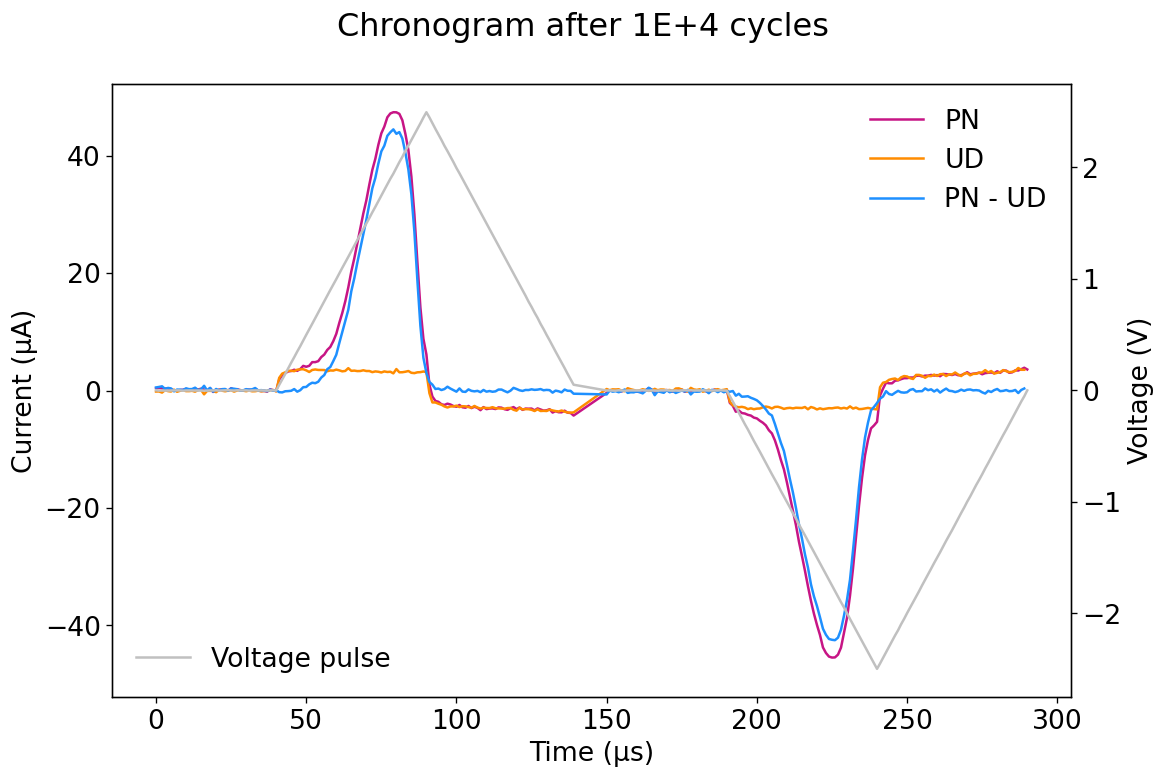

In [125]:
#PLOT THE CHRONOGRAM WITH TIME AS X SCALE

a = "{:.0E}".format(Decimal(Cycle_to_plot))
timer0 = getTime(Index, P_current[Index], N_current[Index], timescale)          #the timescale isn't the same between each segment
timer1 = getTime(Index, U_current[Index], D_current[Index], timescale)

plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

if float(a) < 100:
    if a==1:
        fig.suptitle('Chronogram at pristine state')
    else:
        abis = float(a)
        fig.suptitle('Chronogram after '  + str(int(abis)) + ' cycles')
else:
    fig.suptitle('Chronogram after '  + a + ' cycles')

ax1 = fig.add_subplot(111)

ax1.plot(timer0,PN_current[Index].Current*units*f, "mediumvioletred", label = 'PN')
ax1.plot(timer1,UD_current[Index].Current*units*f, "darkorange", label = 'UD')
plt.plot(timer0,(PN_current[Index].Current-UD_current[Index].Current)*units*f, "dodgerblue", label = 'PN - UD')
ax1.set_ylabel('Current (µA)')
ax1.set_xlabel('Time (µs)')
#ax1.set_ylim([-1000,1000])
ax1.set_ylim([max(abs(PN_current[Index].Current))*units*1.1*f,-max(abs(PN_current[Index].Current))*units*1.1*f])       #change the sign of the limits depending of the setup
plt.legend(loc="upper right", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2 = ax1.twinx()
ax2.plot(timer0,PN_current[Index].Voltage, 'silver', label = 'Voltage pulse')
ax2.set_ylabel('Voltage (V)')
plt.legend(loc="lower left", frameon = False)
plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_' + 'chronogram at '  + a + ' cycles.png'), bbox_inches='tight') #saves the figure in .png

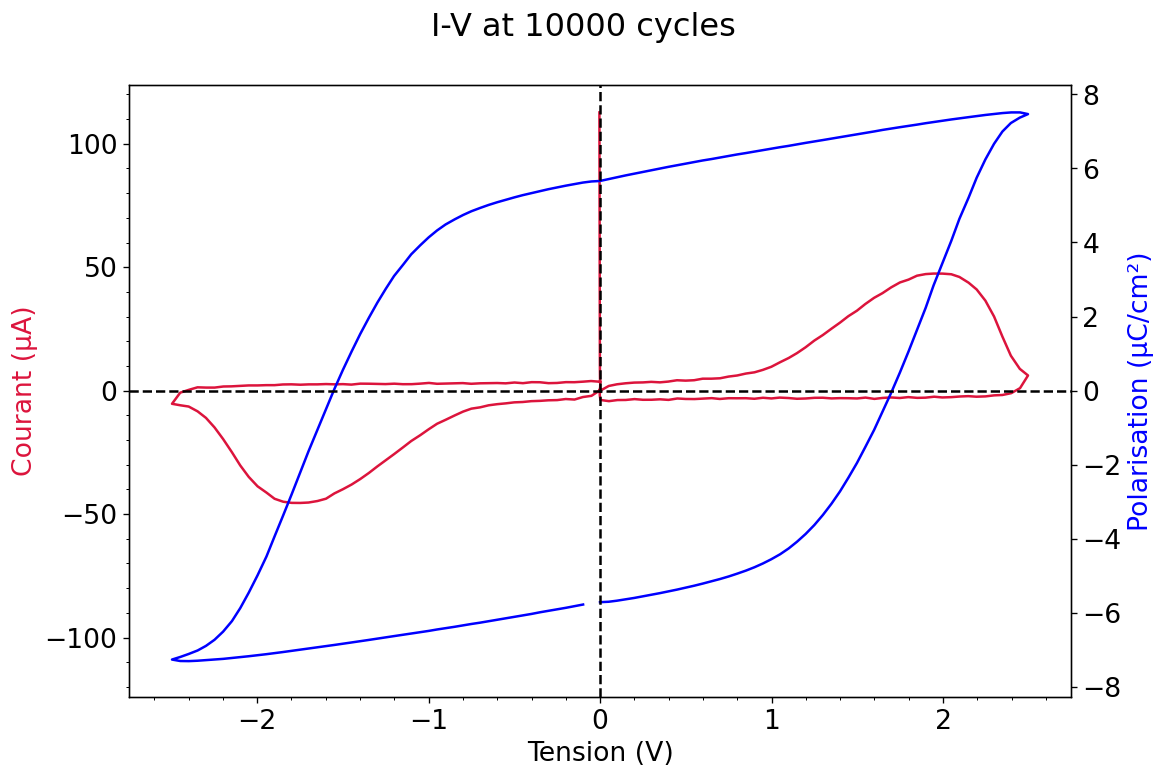

In [108]:
#SAME WITH VOLTAGE AS X SCALE
#Choose the cycle you want to plant by defining the Cycle_to_plot variable
#Cycle_to_plot = 2
#Index = CyclesID.index(Cycle_to_plot)
#a = '%.2E' % Decimal(Cycle_to_plot)
#timescale = 1e6                        #define the timescale to plot (default in µs)
#units = 1e6                            #define the units (default is µA)
#f = -1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)

P_pos, P_neg, Pr_pos, Pr_neg, V_pos, V_neg = getPUND(P_current[Index], N_current[Index], f, Waiting)
P_up, P_down, Pr_up, Pr_down, V_up, V_down = getPUND(U_current[Index], D_current[Index], f, Waiting)
#print(len(P_pos),len(P_up),len(V_pos),len(V_up))
#print(len(P_neg),len(P_down),len(V_neg),len(V_down))
[P_pos, P_up, V_pos, V_up] = the_equalizer([P_pos, P_up, V_pos, V_up])
[P_neg, P_down, V_neg, V_down] = the_equalizer([P_neg, P_down, V_neg, V_down])
P_neg, Pr_neg = rescale(P_pos, P_neg, Pr_neg)
P_down, Pr_down = rescale(P_up, P_down, Pr_down)
Ppn = np.concatenate([P_pos,P_neg], axis=0)
Ppund = np.concatenate([P_pos-P_up,P_neg-P_down], axis=0)
Vpund = np.concatenate([V_pos,V_neg], axis=0)

plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

if float(a) < 100:
    if a==1:
        fig.suptitle('I-V at pristine state')
    else:
        abis = float(a)
        fig.suptitle('I-V at '  + str(int(abis)) + ' cycles')
else:
    abis = float(a)
    fig.suptitle('I-V at '  + str(int(abis)) + ' cycles')
ax1 = fig.add_subplot(111)

ax1.plot(PN_current[Index].Voltage,PN_current[Index].Current*units*f, "crimson")
#ax1.plot(UD_current[Index].Voltage,abs(UD_current[Index].Current*units*f), "darkorange", label = 'UD')
#plt.plot(PN_current[Index].Voltage,abs((PN_current[Index].Current-UD_current[Index].Current)*units*f), "dodgerblue", label = 'PN - UD')
ax1.minorticks_on()
#ax1.tick_params(axis='y', which='minor', left=False)
ax1.set_ylabel('Courant (µA)', color = 'crimson')
ax1.set_xlabel('Tension (V)')
#ax1.set_yscale('log')
ax1.set_ylim([-1.1*units*max(abs(min(PN_current[Index].Current)),max(PN_current[Index].Current)),1.1*units*max(abs(min(PN_current[Index].Current)),max(PN_current[Index].Current))])       #change the sign of the limits depending of the setup

ax2 = ax1.twinx()
ax2.plot(Vpund, Ppn, "blue")
ax2.set_ylim([-1.1*max(abs(min(P_neg)),max(P_pos)),1.1*max(abs(min(P_neg)),max(P_pos))])
ax2.set_ylabel('Polarisation (µC/cm\u00b2)', color = 'blue')

plt.axvline(x=0, ls='--', color='black')
plt.axhline(y=0, ls='--', color='black')
#plt.legend(loc="lower right", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_' + 'P-V at '  + a + ' cycles.png'), bbox_inches='tight') #saves the figure in .png

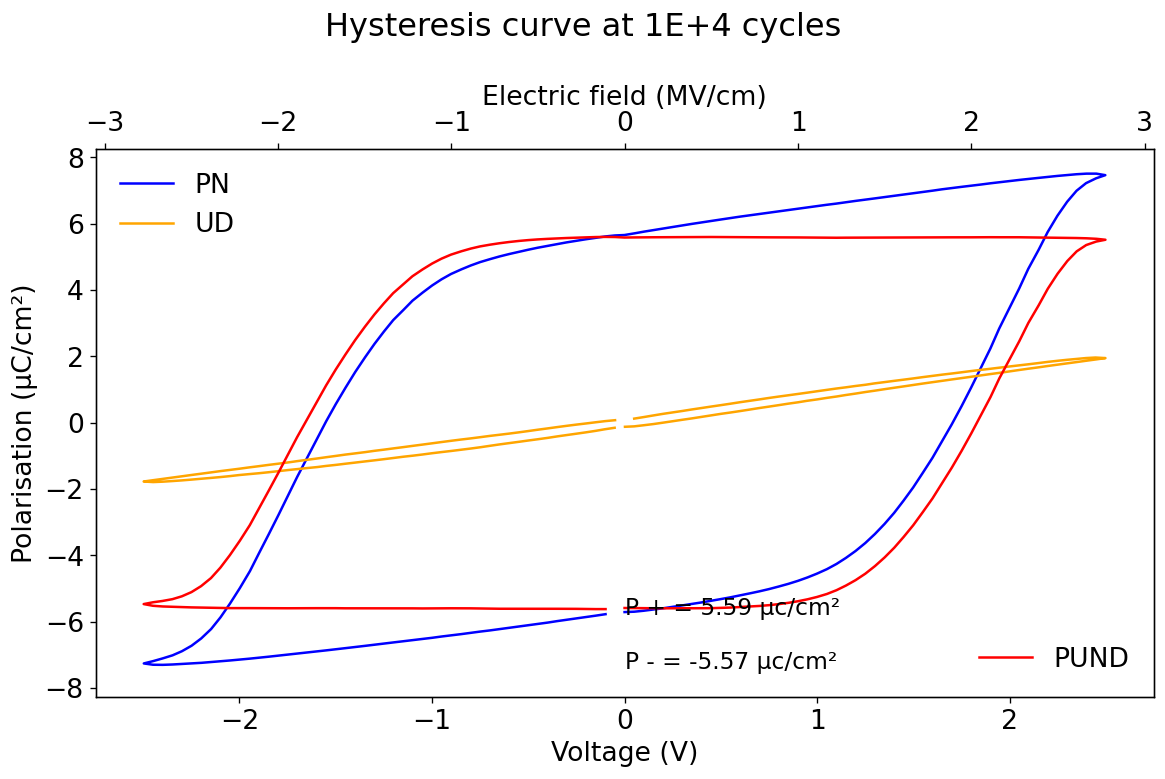

In [109]:
#PLOT THE HYSTERESIS CURVE
#Choose the cycle you want to plant by defining the Cycle_to_plot variable
#Cycle_to_plot = 2
#Index = CyclesID.index(Cycle_to_plot)
#a = '%.2E' % Decimal(Cycle_to_plot)
#timescale = 1e6                        #define the timescale to plot (default in µs)
#units = 1e6                            #define the units (default is µA)
#f = 1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)
    
plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Hysteresis curve at '  + a + ' cycles')
ax1 = fig.add_subplot(111)

ax1.plot(Vpund, Ppn, "blue", label = 'PN')
ax1.plot(V_up, P_up, "orange", label = 'UD')
ax1.plot(V_down, P_down, "orange")
#ax1.set_xlim([-4,4])
ax1.set_ylim([-1.1*max(abs(min(P_neg)),max(P_pos)),1.1*max(abs(min(P_neg)),max(P_pos))])
ax1.set_ylabel('Polarisation (µC/cm\u00b2)')
ax1.set_xlabel('Voltage (V)')
plt.legend(loc="upper left", frameon = False)

ax2 = ax1.twiny()
ax2.plot(Vpund*1e-6/t_ox, Ppund, "red", label = 'PUND')
ax2.set_xlabel('Electric field (MV/cm)')
#ax2.set_xlim([-4,4])
xlim = (ax2, [-4*1e-6/t_ox, 4*1e-6/t_ox])
plt.legend(loc="lower right", frameon = False)
plt.text(0.5, 0.15, "P + = {:04.2f} µc/cm\u00b2" .format(Pr_pos-Pr_up),horizontalalignment='left', fontsize=14, transform = ax1.transAxes)
plt.text(0.5, 0.05, "P - = {:04.2f} µc/cm\u00b2" .format(Pr_neg-Pr_down),horizontalalignment='left', fontsize=14, transform = ax1.transAxes)

plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_' + 'PUND hysteresis at '  + a + ' cycles.png'), bbox_inches='tight') #saves the figure in .png

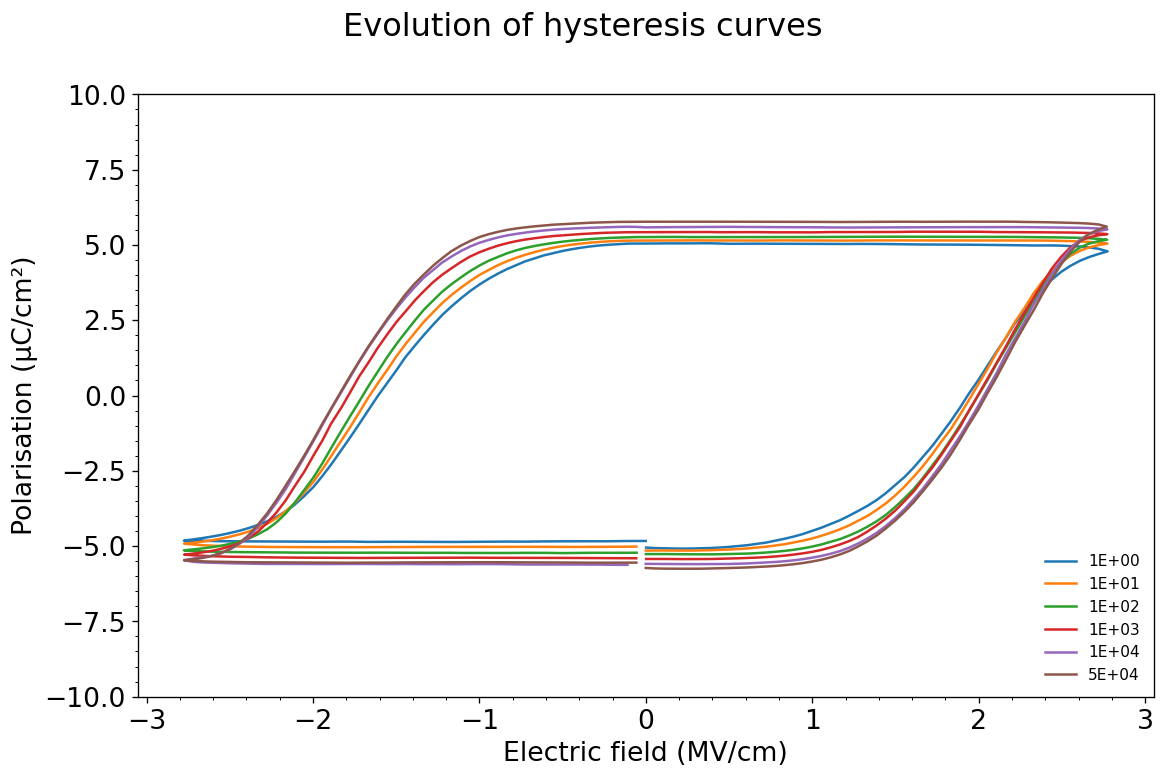

In [110]:
#PLOT THE EVOLUTION OF HYSTERESIS CURVES
#Choose the cycle you want to plant by defining the Cycle_to_plot variable
#Cycle_to_plot = 2
#Index = CyclesID.index(Cycle_to_plot)
#a = '%.2E' % Decimal(Cycle_to_plot)
#timescale = 1e6                        #define the timescale to plot (default in µs)
#units = 1e6                            #define the units (default is µA)
f = -1                                 #define if the current is measured with the opposite channel (equals to 1 or -1)

plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of hysteresis curves')

Pr_plus = []
Pr_minus = []
Ppund = []
Ppund_pos = []
Ppund_neg = []
Epund = []
Epund_pos = []
Epund_neg = []
Ec_pos = []
Ec_neg = []
leak_pos = []
leak_neg = []
leakd_pos = []
leakd_neg = []
x=0

#CyclesID = CyclesID[:-1]  
for i in range(0,len(CyclesID)):
    P_pos, P_neg, Pr_pos, Pr_neg, V_pos, V_neg = getPUND(P_current[i], N_current[i], f, Waiting)
    P_up, P_down, Pr_up, Pr_down, V_up, V_down = getPUND(U_current[i], D_current[i], f, Waiting)
    [P_pos, P_up, V_pos, V_up] = the_equalizer([P_pos, P_up, V_pos, V_up])
    [P_neg, P_down, V_neg, V_down] = the_equalizer([P_neg, P_down, V_neg, V_down])
    P_neg, Pr_neg = rescale(P_pos, P_neg, Pr_neg)
    P_down, Pr_down = rescale(P_up, P_down, Pr_down)
    A = np.concatenate([P_pos-P_up,P_neg-P_down], axis=0)
    Ppund.append(A)                                               #save the entire hysteresis
    Ppund_pos.append(P_pos-P_up)                 #save the positive and negative part of the hysteresis separately
    Ppund_neg.append(P_neg-P_down)
    B = np.concatenate([V_pos*1e-6/t_ox,V_neg*1e-6/t_ox], axis=0)
    Epund.append(B)
    Epund_pos.append(V_pos*1e-6/t_ox)
    Epund_neg.append(V_neg*1e-6/t_ox)
    Pr_plus.append(Pr_pos-Pr_up)                          #save the remanent polarisation values by taking the last value of each half hysteresis
    Pr_minus.append(Pr_neg-Pr_down)
    Ec_pos.append(get_Ec(Ppund_pos[i], Epund_pos[i]))      #save the coercive field
    Ec_neg.append(get_Ec(Ppund_neg[i], Epund_neg[i]))
    
    leak_p, leak_n,leakd_p, leakd_n = get_leakage (P_current[i], N_current[i], f, Waiting)
    leak_pos.append(leak_p)
    leak_neg.append(leak_n)
    leakd_pos.append(leakd_p)
    leakd_neg.append(leakd_n)
    
    if CyclesID[i]==1 or CyclesID[i] == 10**x or i == len(CyclesID)-1: #or i % 9 == 4:
        ID = '%.0E' % Decimal(CyclesID[i])
        plt.plot(B, A, label=str(ID))
        x+=1

scale_factor = 1.1
ymin, ymax = plt.ylim()
if abs(ymin) >= abs(ymax):
    plt.ylim([round_x(ymin, 5), -round_x(ymin, 5)])
else:
    plt.ylim([-round_x(ymax, 5), round_x(ymax, 5)])
#plt.ylim([-25,25])
plt.xlabel('Electric field (MV/cm)')
plt.minorticks_on()
plt.ylabel('Polarisation (µC/cm\u00b2)')
plt.legend(loc="lower right", frameon = False, fontsize = 'xx-small')

plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_' + 'evolution_of_PUND_hysteresis.png'), bbox_inches='tight') #saves the figure in .png

/tmp/ipykernel_242/3292085729.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


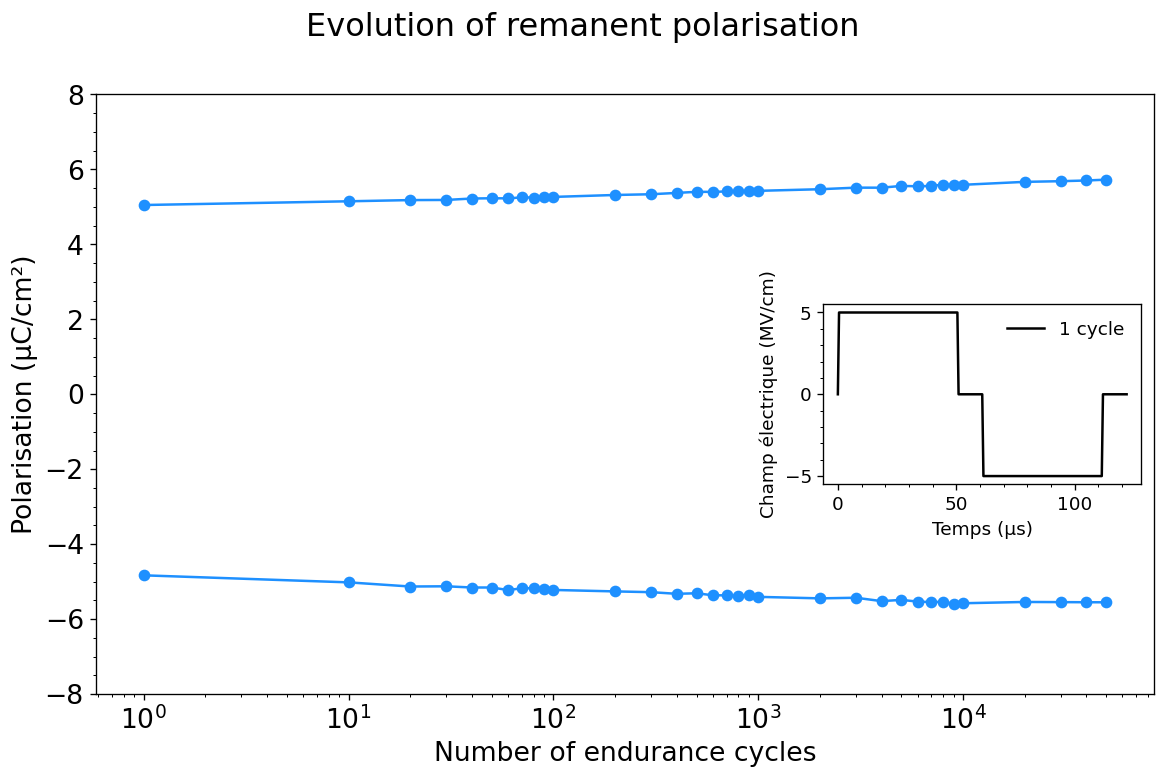

In [111]:
## plt.rcParams.update({'font.size': 16})
my_dpi = 120           #define the quality of the graph depending on your screen, can be set to [96, 120, 144, 192, 240, 288, 384, 480] 
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)
ax = fig.add_subplot(111)
fig.suptitle('Evolution of remanent polarisation')

# Create inset of width 30% and height 40% of the parent axes' bounding box
# at the lower left corner (loc=3)
axins = inset_axes(ax, width="30%", height="30%", loc='center right')
#CyclesID = CyclesID[:-1]
ax.plot(CyclesID, Pr_plus,'o-',color = 'dodgerblue')
ax.plot(CyclesID, Pr_minus,'o-',color = 'dodgerblue')

ax.set_xscale("log")
ax.set_xlabel('Number of endurance cycles')
ax.set_ylabel('Polarisation (µC/cm\u00b2)')
scale_factor = 1.1
ymin, ymax = ax.get_ylim()
if abs(ymin) >= abs(ymax):
    ax.set_ylim([round_x(ymin, 2), -round_x(ymin, 2)])
else:
    ax.set_ylim([-round_x(ymax, 2), round_x(ymax, 2)])
#ax.set_ylim([-22,22])
ax.minorticks_on()
#ax.legend(loc="best" , frameon=False)

Time, Efield = create_cycle(Vmax*2, Vmin*2)
axins.plot(Time, Efield, 'black', label = '1 cycle')
axins.set_xlabel('Temps (µs)',fontsize='x-small')
axins.set_ylabel('Champ électrique (MV/cm)', fontsize='x-small')
ymin2, ymax2 = axins.get_ylim()
if abs(ymin2) >= abs(ymax2):
    axins.set_ylim([round_x(ymin2, 0.5), -round_x(ymin2, 0.5)])
else:
    axins.set_ylim([-round_x(ymax2, 0.5), round_x(ymax2, 0.5)])
axins.minorticks_on()
axins.tick_params(axis='both',labelsize='x-small')
axins.legend(loc="upper right", frameon = False, fontsize='x-small')

plt.tight_layout()
#plt.savefig(data_folder + (sample + '_' + FTJ + '_evolution_of_Pr.png'), bbox_inches='tight') #saves the figure in .png

/tmp/ipykernel_242/848170356.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


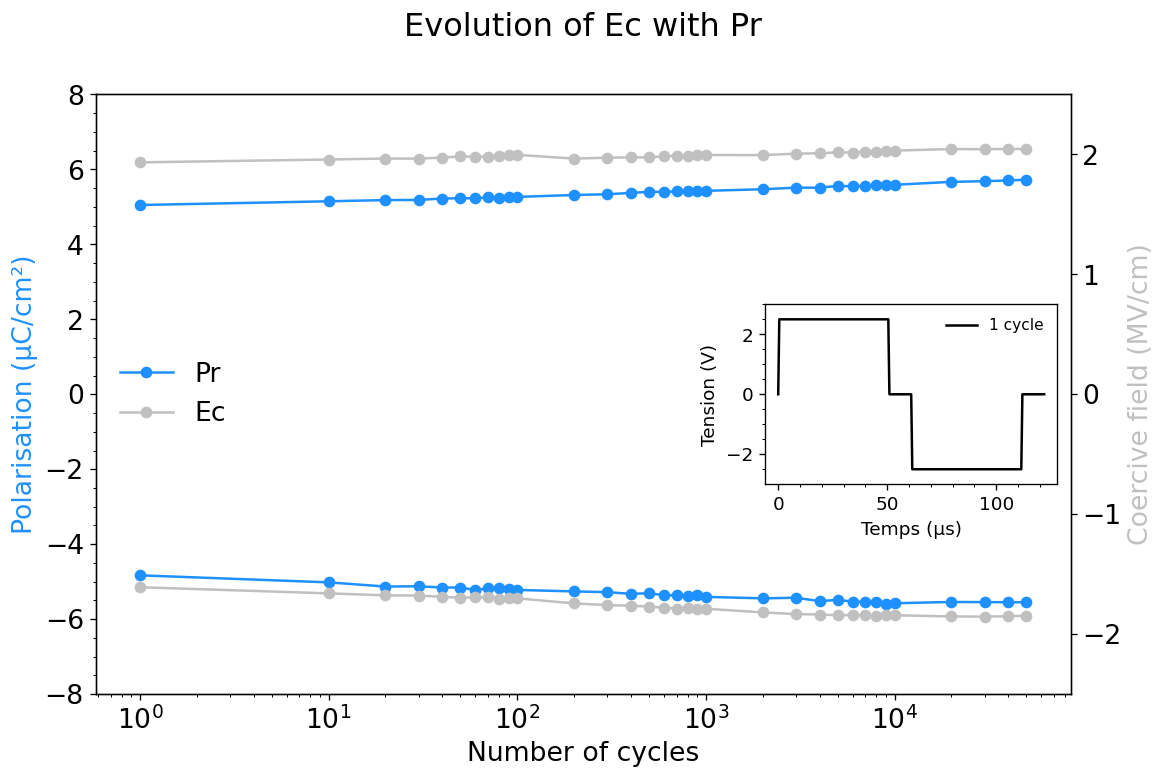

In [112]:
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of Ec with Pr')

ax1 = fig.add_subplot(111)

ax1.plot(CyclesID, Pr_plus,'o-',color = 'dodgerblue', label = 'Pr')
ax1.plot(CyclesID, Pr_minus,'o-',color = 'dodgerblue')
ax1.set_ylabel('Polarisation (µC/cm\u00b2)', color = 'dodgerblue')
ax1.set_xlabel('Number of cycles')
ax1.set_xscale("log")
ax1.minorticks_on()
ymin, ymax = ax1.get_ylim()
if abs(ymin) >= abs(ymax):
    ax1.set_ylim([round_x(ymin, 2), -round_x(ymin, 2)])
else:
    ax1.set_ylim([-round_x(ymax, 2), round_x(ymax, 2)])      #change the sign of the limits depending of the setup
#plt.legend(loc="center left", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2 = ax1.twinx()
ax2.plot(CyclesID, Ec_pos, 'o-',color = 'silver', label = 'Ec')
ax2.plot(CyclesID, Ec_neg, 'o-',color = 'silver')
ax2.set_ylabel('Coercive field (MV/cm)', color = 'silver')
ymin2, ymax2 = ax2.get_ylim()
if abs(ymin2) >= abs(ymax2):
    ax2.set_ylim([round_x(ymin2, 0.5), -round_x(ymin2, 0.5)])
else:
    ax2.set_ylim([-round_x(ymax2, 0.5), round_x(ymax2, 0.5)])
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc='center left', frameon= False)

axins = inset_axes(ax2, width="30%", height="30%", loc='center right')
Time, Efield = create_cycle(Vmax, Vmin)
axins.plot(Time, Efield, 'black', label = '1 cycle')
axins.set_xlabel('Temps (µs)',fontsize='x-small')
axins.set_ylabel('Tension (V)', fontsize='x-small')
ymin3, ymax3 = axins.get_ylim()
if abs(ymin3) >= abs(ymax3):
    axins.set_ylim([round_x(ymin3, 0.5), -round_x(ymin3, 0.5)])
else:
    axins.set_ylim([-round_x(ymax3, 0.5), round_x(ymax3, 0.5)])
axins.minorticks_on()
axins.tick_params(axis='both',labelsize='x-small')
axins.legend(loc="upper right", frameon = False, fontsize='xx-small')

#plt.legend(loc="center right", frameon = False)
plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_evolution_of_Ec_with_Pr.png'), bbox_inches='tight') #saves the figure in .png

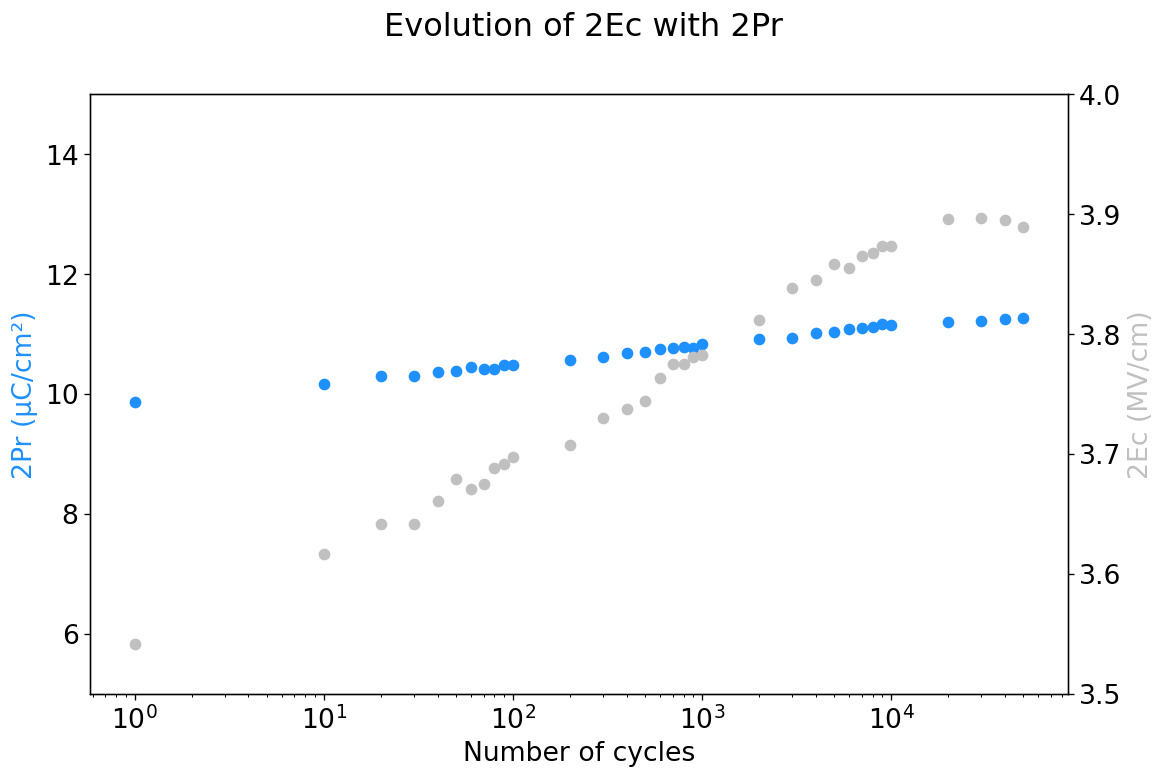

In [113]:
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of 2Ec with 2Pr')

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
for i in range(0,len(CyclesID)):
    ax1.plot(CyclesID[i], Pr_plus[i]-Pr_minus[i],'o-',color = 'dodgerblue')
    ax2.plot(CyclesID[i], Ec_pos[i]-Ec_neg[i], 'o-',color = 'silver')
ax1.set_ylabel('2Pr (µC/cm\u00b2)', color = 'dodgerblue')
ax1.set_xlabel('Number of cycles')
ax1.set_xscale("log")
ymin, ymax = ax1.get_ylim()
ax1.set_ylim([round_x(ymin, 5)-5, round_x(ymax, 5)])
#ax1.set_ylim([30,50])
#ax1.set_ylim([max(abs(PN_current[Index].Current))*units*1.1*f,-max(abs(PN_current[Index].Current))*units*1.1*f])       #change the sign of the limits depending of the setup
#plt.legend(loc="center left", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2.set_ylabel('2Ec (MV/cm)', color = 'silver')
ymin2, ymax2 = ax2.get_ylim()
ax2.set_ylim([round_x(ymin2, 0.5)-0.5, round_x(ymax2, 0.5)])
#ax2.set_ylim([2, 3.5])
#plt.legend(loc="center right", frameon = False)
plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_evolution_of_2Ec_with_2Pr.png'), bbox_inches='tight') #saves the figure in .png

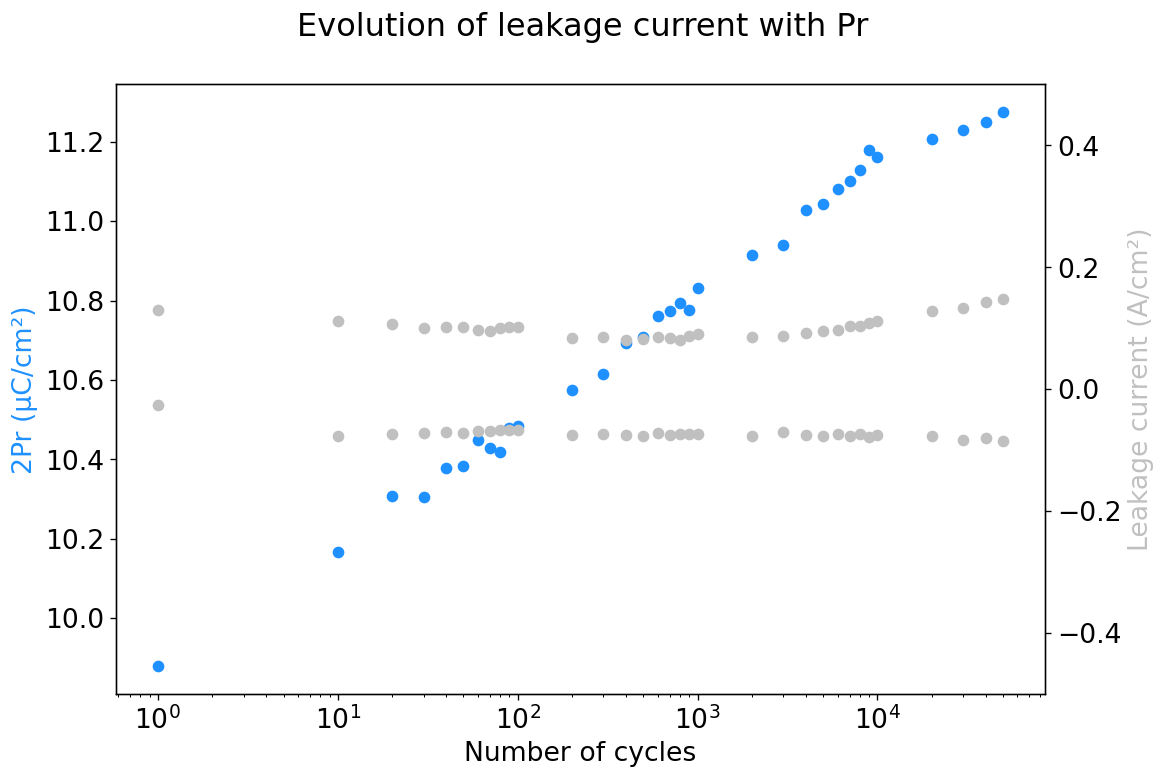

In [114]:
fig = plt.figure(figsize=(1200/my_dpi,800/my_dpi), dpi=my_dpi)   #create an empty figure of a 1200x800 pixel size (depending of the dpi)

fig.suptitle('Evolution of leakage current with Pr')

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
for i in range(0,len(CyclesID)):
    ax1.plot(CyclesID[i], Pr_plus[i]-Pr_minus[i],'o-',color = 'dodgerblue')
    ax2.plot(CyclesID[i], leakd_pos[i], 'o-',color = 'silver')
    ax2.plot(CyclesID[i], leakd_neg[i], 'o-',color = 'silver')
ax1.set_ylabel('2Pr (µC/cm\u00b2)', color = 'dodgerblue')
ax1.set_xlabel('Number of cycles')
ax1.set_xscale("log")
#lim = max(Pr_plus)+max(Pr_minus)
#ax1.set_ylim([0 ,round_x(lim, 5)])
#ax1.set_ylim([max(abs(PN_current[Index].Current))*units*1.1*f,-max(abs(PN_current[Index].Current))*units*1.1*f])       #change the sign of the limits depending of the setup
#plt.legend(loc="center left", frameon = False)
#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

ax2.set_ylabel('Leakage current (A/cm\u00b2)', color = 'silver')
lim2 = max(max(leakd_pos), -min(leakd_neg))
ax2.set_ylim([round_x(-lim2, 0.5), round_x(lim2, 0.5)])
#ax2.set_yscale("log")
#plt.legend(loc="center right", frameon = False)
plt.tight_layout()
plt.savefig(data_folder + (sample + '_' + FTJ + '_evolution_of_leakage current_with_2Pr.png'), bbox_inches='tight') #saves the figure in .png

In [115]:
##Save ferroelectric properties and the hysteresis of each cycle in xls files
Pr = [m - n for m,n in zip(Pr_plus,Pr_minus)]
Ec = [y - z for y,z in zip(Ec_pos,Ec_neg)]

d= {'CyclesID': CyclesID, 'Pr_plus': Pr_plus, 'Pr_minus': Pr_minus, '2Pr': Pr, 'Ec_pos': Ec_pos, 'Ec_neg': Ec_neg, '2Ec': Ec, 'Leakage_pos': leak_pos,'Leakage_neg': leak_neg,'Leakage_density_pos': leakd_pos,'Leakage_density_neg': leakd_neg}
df = pd.DataFrame(data=d)
df.to_csv(data_folder + ('Ferroelectric properties per cycle.csv'), index=False, sep='\t')

print(str(sample)+'-'+str(FTJ)+'\nProperties saved')

datas = {'Electric field (MV/cm)': Epund[0], 'Polarisation (µC/cm\u00b2)':Ppund[0]}
dataf = pd.DataFrame(data=datas)
datas2 = {'Electric field (MV/cm)': PN_current[0].Voltage*1e-6/t_ox,'PN_current (A/cm\u00b2)':PN_current[0].Current*f/S}
dataf2 = pd.DataFrame(data=datas2)
dataf.to_excel(data_folder + ('Hystereses.xlsx'), sheet_name=str(CyclesID[0]))
dataf2.to_excel(data_folder + ('PN_current.xlsx'), sheet_name=str(CyclesID[0]))

with pd.ExcelWriter(data_folder + ('Hystereses.xlsx'), engine= 'openpyxl', mode='a') as writer:
    for i in range(1,len(CyclesID)):
        datas = {'Electric field (MV/cm)': Epund[i], 'Polarisation (µC/cm\u00b2)':Ppund[i]}
        dataf = pd.DataFrame(data=datas)
  
        dataf.to_excel(writer, sheet_name=str(CyclesID[i]))

print('Hystereses saved')

with pd.ExcelWriter(data_folder + ('/PN_current.xlsx'), engine= 'openpyxl', mode='a') as writer2:
    for i in range(1,len(CyclesID)):
        datas2 = {'Electric field (MV/cm)': PN_current[i].Voltage*1e-6/t_ox,'PN_current (A/cm\u00b2)':PN_current[i].Current*f/S}
        dataf2 = pd.DataFrame(data=datas2)
        
        dataf2.to_excel(writer2, sheet_name=str(CyclesID[i]))    

print('PN current saved')

Q294A-tl62
Properties saved
Hystereses saved
PN current saved


In [116]:
(PN_current[Index].Time[:-243]-PN_current[Index].Time[0], PN_current[Index].Current[:-243])

(0     0.000000
 1     0.000001
 2     0.000002
 3     0.000003
 4     0.000004
 5     0.000005
 6     0.000006
 7     0.000007
 8     0.000008
 9     0.000009
 10    0.000010
 11    0.000011
 12    0.000012
 13    0.000013
 14    0.000014
 15    0.000015
 16    0.000016
 17    0.000017
 18    0.000018
 19    0.000019
 20    0.000020
 21    0.000021
 22    0.000022
 23    0.000023
 24    0.000024
 25    0.000025
 26    0.000026
 27    0.000027
 28    0.000028
 29    0.000029
 30    0.000030
 31    0.000031
 32    0.000032
 33    0.000033
 34    0.000034
 35    0.000035
 36    0.000036
 37    0.000037
 38    0.000038
 39    0.000039
 40    0.000040
 41    0.000041
 42    0.000042
 43    0.000043
 44    0.000044
 45    0.000045
 46    0.000046
 47    0.000047
 48    0.000048
 49    0.000049
 50    0.000050
 51    0.000051
 52    0.000052
 53    0.000053
 54    0.000054
 55    0.000055
 56    0.000056
 57    0.000057
 Name: Time, dtype: float64,
 0    -1.126947e-04
 1    -2.919387e-05
 2 

In [117]:
(UD_current[Index].Time[:-245]-UD_current[Index].Time[0], UD_current[Index].Current[:-245])

(0     0.000000
 1     0.000001
 2     0.000002
 3     0.000003
 4     0.000004
 5     0.000005
 6     0.000006
 7     0.000007
 8     0.000008
 9     0.000009
 10    0.000010
 11    0.000011
 12    0.000012
 13    0.000013
 14    0.000014
 15    0.000015
 16    0.000016
 17    0.000017
 18    0.000018
 19    0.000019
 20    0.000020
 21    0.000021
 22    0.000022
 23    0.000023
 24    0.000024
 25    0.000025
 26    0.000026
 27    0.000027
 28    0.000028
 29    0.000029
 30    0.000030
 31    0.000031
 32    0.000032
 33    0.000033
 34    0.000034
 35    0.000035
 36    0.000036
 37    0.000037
 38    0.000038
 39    0.000039
 40    0.000040
 41    0.000041
 42    0.000042
 43    0.000043
 44    0.000044
 45    0.000045
 46    0.000046
 47    0.000047
 48    0.000048
 49    0.000049
 50    0.000050
 51    0.000051
 52    0.000052
 53    0.000053
 Name: Time, dtype: float64,
 0     3.626393e-06
 1     1.919462e-06
 2     1.253342e-06
 3     7.815078e-07
 4     7.676304e-07
 5     

In [118]:
df

,CyclesID,Pr_plus,Pr_minus,2Pr,Ec_pos,Ec_neg,2Ec,Leakage_pos,Leakage_neg,Leakage_density_pos,Leakage_density_neg
0,1.0,5.049066,-4.829613,9.878679,1.933527,-1.608671,3.542198,0.000010,-0.000002,0.130521,-0.026206
1,10.0,5.148633,-5.017438,10.166071,1.957192,-1.659652,3.616844,0.000009,-0.000006,0.112675,-0.076034
2,20.0,5.180659,-5.128093,10.308751,1.965383,-1.676085,3.641469,0.000008,-0.000006,0.107021,-0.073383
3,30.0,5.184325,-5.122129,10.306454,1.964312,-1.677756,3.642068,0.000008,-0.000006,0.100483,-0.072323
4,40.0,5.222580,-5.154729,10.377309,1.973495,-1.687926,3.661421,0.000008,-0.000006,0.101367,-0.070556
5,50.0,5.229029,-5.154464,10.383493,1.982810,-1.696948,3.679759,0.000008,-0.000006,0.102250,-0.071793
6,60.0,5.226909,-5.222049,10.448958,1.980284,-1.690563,3.670848,0.000008,-0.000005,0.097656,-0.068259
7,70.0,5.251601,-5.177125,10.428727,1.981143,-1.694056,3.675200,0.000007,-0.000005,0.095359,-0.068436
8,80.0,5.248995,-5.170455,10.419450,1.985399,-1.703079,3.688478,0.000008,-0.000005,0.099776,-0.066846
9,90.0,5.276029,-5.204027,10.480056,1.990683,-1.700968,3.691650,0.000008,-0.000005,0.101543,-0.066846
